In [12]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import os
from PIL import Image
from scipy.spatial.distance import euclidean
current_directory = os.getcwd()
mnist_directory = os.path.join(current_directory,"../MNIST_CSV")

print("Current Directory:", current_directory)
print("MNIST Directory:", mnist_directory)

Current Directory: c:\Users\Sai\Work\cs490\Summary_Statistics
MNIST Directory: c:\Users\Sai\Work\cs490\Summary_Statistics\../MNIST_CSV


### Loading the data 
The MNIST data is saved as CSV files with flattened vectors rather than raw image data. The shape outputted is 60000 and 10000 for the train and test data set respectively but the data comes with no headers. Each row has 785 columns because they flatten 28 x 28 pixel images into 1d vectors.

In [13]:
# Load the data from CSVs using pandas
mnist_train = pd.read_csv(os.path.join(mnist_directory, "mnist_train.csv"), header=None)

mnist_test = pd.read_csv(os.path.join(mnist_directory, "mnist_test.csv"), header=None)

# Metadata
print(f"Unique Labels: {len(set(mnist_train[0]))}, {set(mnist_train[0])}")
print("Train Dataset Shape:")
print(mnist_train.shape)
print("Test Dataset Shape:")
print(mnist_test.shape)
mnist_train.head()

Unique Labels: 10, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Train Dataset Shape:
(60000, 785)
Test Dataset Shape:
(10000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### PCA 

Number of Components: 164


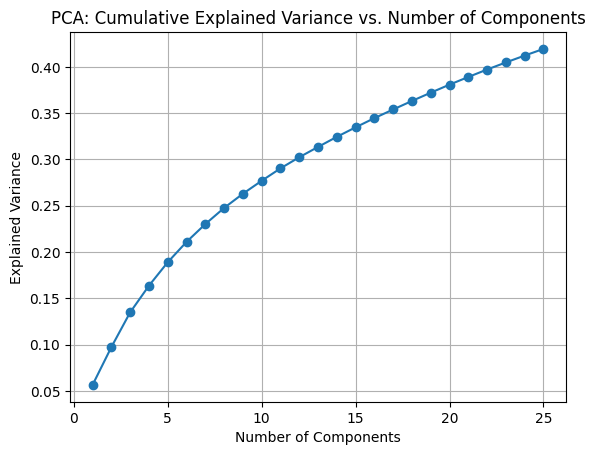

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = mnist_train

# Standardize the data
X_std = StandardScaler().fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_std)

# Get the eigenvalues
eigenvalues = pca.explained_variance_

# Count the number of eigenvalues greater than 1
num_components = np.sum(eigenvalues > 1)

print(f"Kaiser's Rule for Necessary Number of Components: {num_components}")

# Plot the cumulative explained variance ratio
explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, 26), explained_variance_ratio_cumsum[:25], marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('PCA: Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

### Class Balance
Occasionally, balancing the train data can prevention biased models when the data is extremely balanced towards a certain class. Here, the train and test data frequency is plotted. Since they're mostly even the classes aren't too imbalanced. Just in case, code is included for balancing the train data for future use. The test data should NEVER be balanced because that might misrepresent the true underlying distribution.  

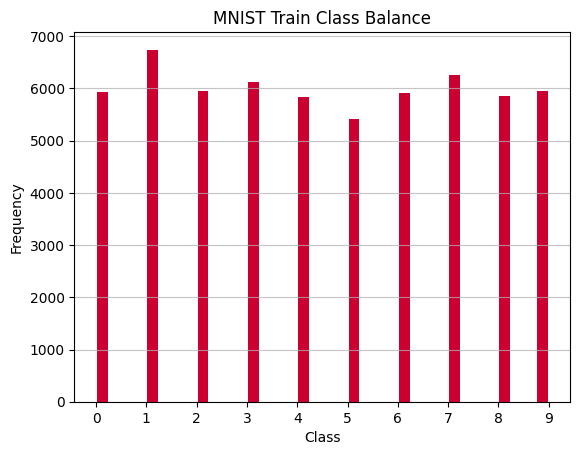

In [15]:
plt.hist(mnist_train[0], bins='auto', color='#cb0030', rwidth=0.85)
plt.xticks(range(0, 10))
plt.title('MNIST Train Class Balance')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

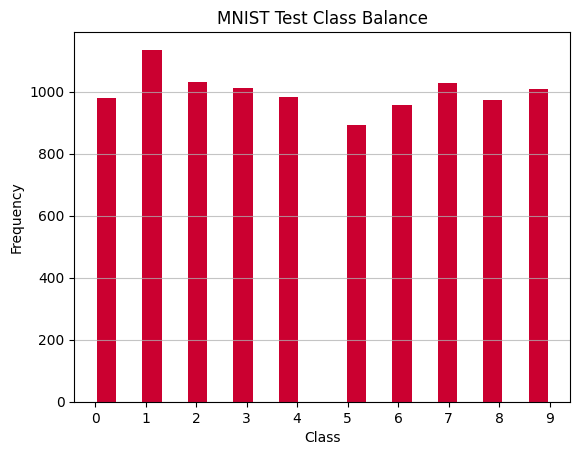

In [16]:
plt.hist(mnist_test[0], bins='auto',color='#cb0030',  rwidth=0.85)
plt.xticks(range(0, 10))
plt.title('MNIST Test Class Balance')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

### Transforming one-hot vectors to viewable image data
Since the data is a one-hot vector, we can strip the label, unflatten the 784 columns into 24 x 24 matrices, and convert them to PIL images for viewing. 
It's important that we do NOT modify the pixel intensity so that the original data is kept intact. Gaussian Blurring may be a technique that could be considered for enhancing image processing techniques.

In [17]:

def row_to_image(vector):
    """
    Convert a single record into a viewable image. While we transform the entire dataset below, 
    this function will be useful if we do operations on one-hot vectors and 
    need to view the output as an human-interpretable image

    Parameters:
    - One-hot vector where the first element is the label and the other 784 elements are the image data

    Returns: 
    - the label and a numpy array representing the image data

    Example:
        # Sample a vector from the mnist dataset and convert it to image data
        label, feature = row_to_image(mnist_train.iloc[0])
        image = Image.fromarray(feature.astype(np.uint8))
        
        # Display the image
        image.show()
    """
    label = vector.iloc[0]
    feature_data = vector.iloc[1:].to_numpy().reshape(28, 28)
    return label, feature_data

In [18]:
# Convert the Data back into viewable images
labelData = mnist_train.iloc[:, 1].to_numpy()
featureData = mnist_train.drop(mnist_train.columns[0], axis=1)
featureData = featureData
featureData = featureData.to_numpy().reshape(featureData.shape[0], 28, 28)
xImageTrain = featureData 
yImageTrain = labelData

In [19]:
# Sample an Image from the converted dataset
image = Image.fromarray(xImageTrain[0].astype(np.uint8))
# Display the image
image.show()

image = Image.fromarray(xImageTrain[0].astype(np.uint8))

### Mean Image Vector (per label)
Given that we know MNIST's dataset consists of images of numbers 0 to 10 with similar framing, we can compute the mean image vector to get an idea what the "average" image for each number will look like. We do this by grouping the records by label, and then computing the mean of that group (column wise). Note that the color map is changed in the visualization but the image is still black and white.

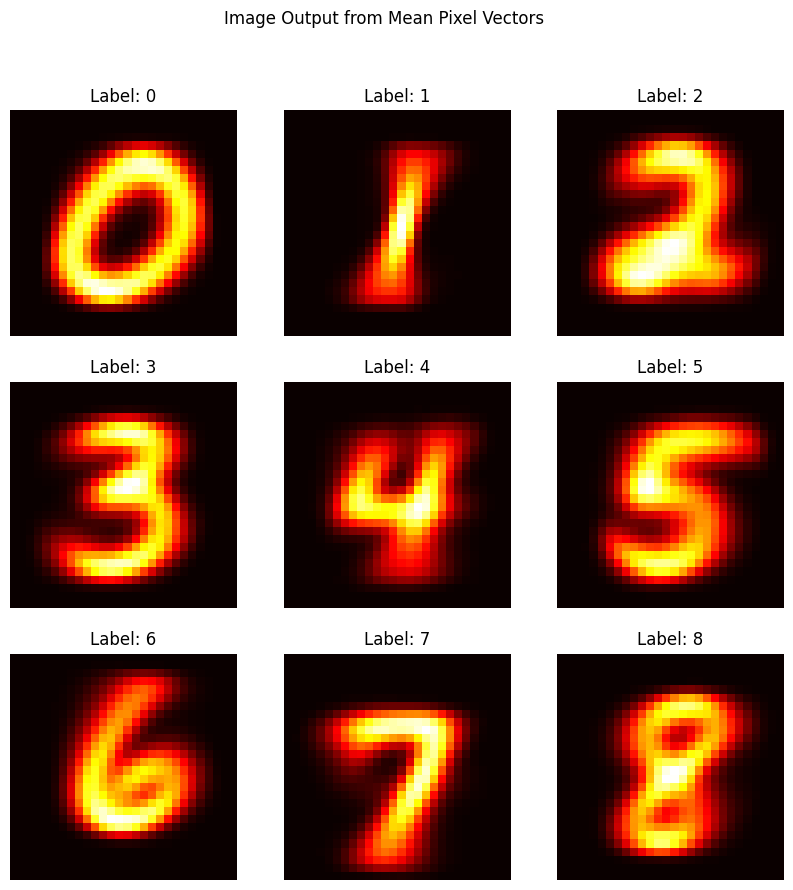

In [20]:
# Group by the first column (label) and compute the mean for each group
grouped_means = mnist_train.groupby(0).mean()

# Reset index to have a clean DataFrame
grouped_means.reset_index(inplace=True)

# Convert the grouped means to images
mnist_images = [row_to_image(row) for _ , row in grouped_means.iterrows()]

# Display the images as a 3x3 matrix using matplotlib
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Image Output from Mean Pixel Vectors')

for i in range(3):
    for j in range(3):
        index = i * 3 + j
        label, feature_image = mnist_images[index]
        
        axes[i, j].imshow(feature_image, cmap='hot')
        axes[i, j].set_title(f"Label: {int(label)}")
        axes[i, j].axis('off')


plt.show()

### Distance from the Mean Vector
To get an idea of how much images vary our mean vector we can calculate the euclidean distance of between each record and the mean record for that record's label. Summary statistics on our distances to will help measure how robust our dataset is.

In [21]:
# Calculate Euclidean distances between each vector and the mean vector
distances = {}

for index, row in mnist_train.iterrows():
    label = int(row.iloc[0])
    feature_data = row.iloc[1:].to_numpy()
    mean_vector = grouped_means.iloc[label, 1:].to_numpy()

    distance = euclidean(feature_data, mean_vector)
    
    if label not in distances:
        distances[label] = []
    
    distances[label].append(distance)

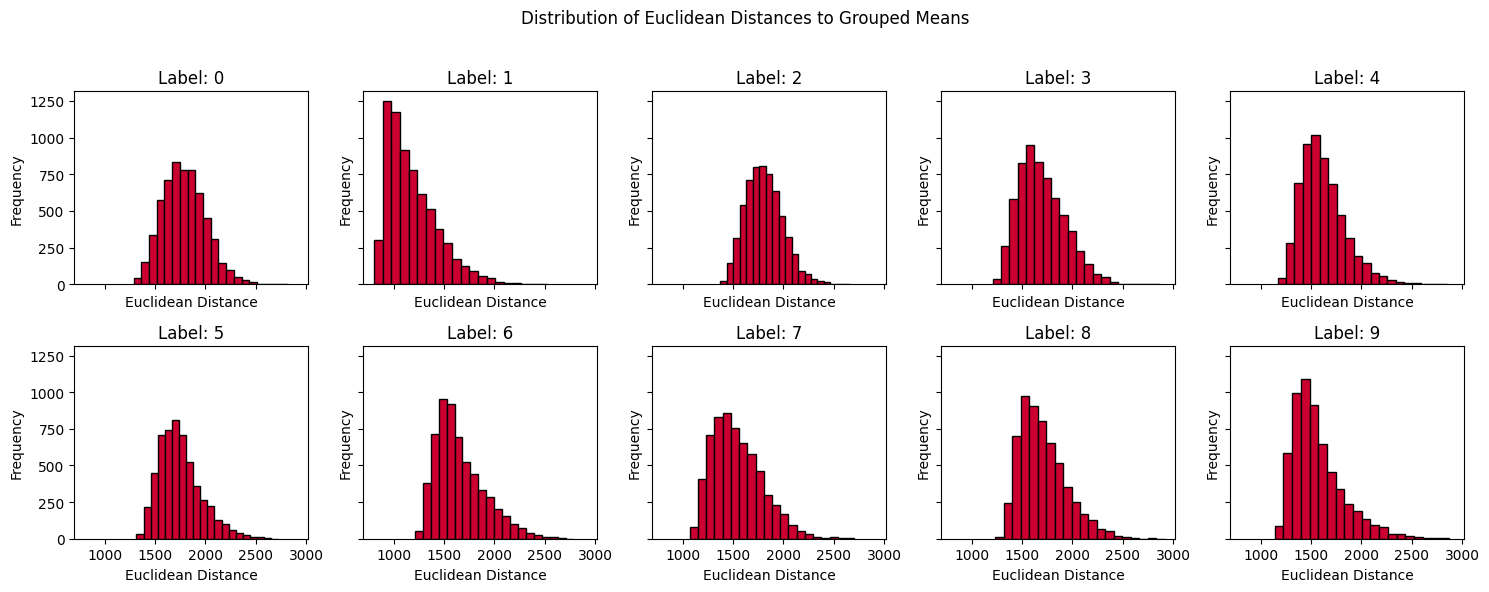

In [22]:
# Plotting Distances

# Create subplots for each label in increasing order
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)
fig.suptitle('Distribution of Euclidean Distances to Grouped Means')

# Sort labels in increasing order
sorted_labels = sorted(distances.keys())

# Plot histograms for each label
for i, label in enumerate(sorted_labels):
    dist_values = distances[label]
    ax = axes[i // 5, i % 5]
    ax.hist(dist_values, bins=20, color='#cb0030', edgecolor='black')
    ax.set_title(f'Label: {label}')
    ax.set_xlabel('Euclidean Distance')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [23]:
# Printing Summary Statistics to an output file for each label 

summary_statistics = {}

for label, dist_values in distances.items():
    summary_statistics[label] = {
        'Mean': round(np.mean(dist_values), 2),
        'Standard Deviation': round(np.std(dist_values), 2),
        'Variance': round(np.var(dist_values), 2),
        '25th Percentile': round(np.percentile(dist_values, 25), 2),
        'Median': round(np.median(dist_values), 2),
        '75th Percentile': round(np.percentile(dist_values, 75), 2),
        'Min': round(np.min(dist_values), 2),
        'Max': round(np.max(dist_values), 2)
    }

# Define the output file path
output_file_path = 'mnist_summary_statistics.txt'

# Open the output file and print summary statistics
with open(output_file_path, 'w') as output_file:
    for label in sorted(summary_statistics.keys()):
        stats = summary_statistics[label]
        output_file.write(f"Label {label} Summary Statistics:\n")
        for stat_name, stat_value in stats.items():
            output_file.write(f"{stat_name}: {stat_value}\n")
        output_file.write("\n")

print(f"Summary statistics saved to: {output_file_path}")


Summary statistics saved to: mnist_summary_statistics.txt
